In [1]:
import numpy as np
import pandas as pd
import datetime
import requests
from pathlib import Path
from dotenv import dotenv_values

import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce



No GPU found


In [2]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [3]:

# Config
BASE_URL = "https://crabtrades.com" 
SYMBOL = "AAPL"
TIME_FRAME = "6Hour"
USE_SAVED_MODEL = True
SHOULD_TRADE = False
DOWNLOAD_DATASET = True
RISK_PER_TRADE = 0.05

dir_path = os.path.dirname(os.path.realpath(__file__)) + "/"
env_config = dotenv_values(dir_path + ".env")
ADMIN_KEY = env_config["ADMIN_KEY"]
ALPACA_API_KEY = env_config["ALPACA_API_KEY"]
ALPACA_SECRET_KEY = env_config["ALPACA_SECRET_KEY"]

In [4]:

def download_dataset():
    current_utc_time = datetime.datetime.utcnow()
    end_date = current_utc_time.strftime("%Y-%m-%d") + "T00:00:00.000Z"
    start_date = "2016-01-01T00:00:00.000Z"

    if DOWNLOAD_DATASET or not Path(dir_path + 'dataset.csv').is_file():
        try:
            response = requests.post(BASE_URL + "/api/fetchHistoricalStock", headers={
                "Enddate": end_date,
                "Startdate": start_date,
                "Symbol": SYMBOL,
                "Timeframe": TIME_FRAME,
                "admin-token": ADMIN_KEY
            })

        except requests.exceptions.RequestException as e:
            raise SystemExit(f"[/api/fetchHistoricalStock] Request error: {e}")

        if(response.status_code != 200):
            print(response.text)
            raise SystemExit(f"[/api/fetchHistoricalStock] Repsonse status code: {response.status_code}")

        parsed_json = response.json()

        df = pd.DataFrame(parsed_json)
        df.to_csv('dataset.csv', index=False)
        return df

    return pd.DataFrame()


In [5]:
df = download_dataset()
print(df.head(5))

   ClosePrice  HighPrice  LowPrice  OpenPrice  TradeCount Symbol  \
0       26.37      26.38     26.34      26.36          65   AAPL   
1       25.75      26.36     25.75      26.36         418   AAPL   
2       26.20      26.22     25.50      25.75      213938   AAPL   
3       26.44      26.44     25.96      26.20      136873   AAPL   
4       26.44      26.45     26.42      26.44          88   AAPL   

              Timestamp     Volume       VWAP  
0  2016-01-01T00:00:00Z      46584  26.357518  
1  2016-01-04T06:00:00Z     343344  25.902346  
2  2016-01-04T12:00:00Z  137606672  25.815909  
3  2016-01-04T18:00:00Z  149553364  26.213155  
4  2016-01-05T00:00:00Z      95620  26.436887  


In [6]:

def make_prediction(df):
    df = pd.read_csv(dir_path + 'dataset.csv')
    df.rename(columns={
        "ClosePrice": "Close", 
        "HighPrice": "High", 
        "LowPrice": "Low", 
        "OpenPrice": "Open", 
        "Timestamp": "Date",
        "TradeCount": "Trades"
    }, inplace=True)
    df.index = pd.to_datetime(df["Date"])
    df = df[["Open", "High", "Low", "Volume", "VWAP", "Trades", "Close"]]

    # https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    pd.options.mode.copy_on_write = True

    # Add running averages of 200 and 50 days
    df.loc[:, '200MA'] = df['Close'].rolling(window=200).mean()
    df.loc[:, '50MA'] = df['Close'].rolling(window=50).mean()
    df = df.dropna()
    df[["Open", "High", "Low", "Volume", "VWAP", "Trades", "200MA", "50MA", "Close"]]
    print(df.head(5))
    
    # Feature scaling
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[["Open", "High", "Low", "Volume", "VWAP", "Trades", "200MA", "50MA", "Close"]])
    scaled_data[10] # sequence_length. Take a look at last number, and y's first number

    # Create sequences of data for input and target
    def create_sequences(data, sequence_length):
        X, y = [], []
        for i in range(len(data) - sequence_length):
            X.append(data[i:(i+sequence_length)])
            y.append(data[i+sequence_length, 8])  # 6 corresponds to the 'Close' column
        return np.array(X), np.array(y)

    sequence_length = 10  # You can adjust this window size based on your needs
    X, y = create_sequences(scaled_data, sequence_length)

    # Split the data into training and testing sets
    SPLIT = 0.9
    split = int(SPLIT * len(X))
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    fit_history = None
    if USE_SAVED_MODEL and Path(dir_path + "model.keras").exists() and Path(dir_path + "model.keras").is_file():
        # Load the model
        model = tf.keras.models.load_model(dir_path + 'model.keras')
    else:
        # Train the model
        fit_history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)
        model.save(dir_path + 'model.keras')

    # Evaluate the model on the test 
    if y_test.size != 0:
        loss = model.evaluate(X_test, y_test)
        print(f'Mean Squared Error on Test Set: {loss}')

        # Predict future closes
        predicted_closes = model.predict(X_test)

    # Use the last sequence_length days' data for tomorrow prediction
    last_window = scaled_data[-sequence_length:]

    # Reshape the data for prediction
    last_window = last_window.reshape(1, sequence_length, last_window.shape[1])

    # Make a prediction for the next day
    predicted_close = model.predict(last_window)

    # Inverse transform the prediction to get the actual closing price
    predicted_close = scaler.inverse_transform(np.concatenate((last_window[:, -1, :-1], predicted_close.reshape(-1, 1)), axis=1))[:, -1]

    # If price tommorow is bigger than today, we should buy
    should_buy = predicted_close > df['Close'][df.index[-1]]

    print(f'Predicted Close for the Next Day: {predicted_close[0]}')
    print(f'Today: {df["Close"][df.index[-1]]}')
    print(f'Should buy: {should_buy}')

    if is_notebook():
        # Plot the model' training loss
        if fit_history is not None:
            plt.plot(fit_history.history["loss"][3:], label='Training Loss')
            plt.legend()
            plt.show()

        # Evaluate the model on the test 
        if y_test.size != 0:
            loss = model.evaluate(X_test, y_test)
            print(f'Mean Squared Error on Test Set: {loss}')

            # Predict future closes
            predicted_closes = model.predict(X_test)
            plt.plot(df.index[-len(y_test):], y_test, label='True Close Prices', c='b')
            plt.plot(df.index[-len(y_test):], predicted_closes, label='Predicted Close Prices', c='r')
            plt.legend()
            plt.show()

        # Simulate trading
        predictions_df = pd.DataFrame(index=df.index, columns=['Actual Close', 'Predicted Close', "BuySell"])
        print("Predicted: 0 / 0: 0", end='')
        for i in range(len(scaled_data) - 100, len(scaled_data)):
            # Extract the last 10 days' data
            window = scaled_data[i - sequence_length:i].reshape(1, sequence_length, scaled_data.shape[1])
            
            # Make a prediction
            predicted_close = model.predict(window, verbose=0)
            
            # Inverse transform the prediction to get the actual closing price
            predicted_close = scaler.inverse_transform(np.concatenate((window[:, -1, :-1], predicted_close.reshape(-1, 1)), axis=1))[:, -1]
            
            # Inverse transform the actual closing price
            actual_close = scaler.inverse_transform(scaled_data[i:i+1])[:, -1]
            
            # Store the actual and predicted closes in the DataFrame
            predictions_df.loc[df.index[i], 'Actual Close'] = actual_close[0]
            predictions_df.loc[df.index[i], 'Predicted Close'] = predicted_close[0]

            print(f'\rPredicted: {i} / {len(scaled_data)}: {predicted_close[0]}', end='')

            predictions_df.loc[df.index[i], 'BuySell'] = "Hold"
            if(i + 1 >= len(scaled_data)):
                continue
            
            yesterday_close =  predictions_df.loc[df.index[i - 1], 'Actual Close']
            predictions_df.loc[df.index[i], 'BuySell'] = "Sell" if predicted_close[0] < yesterday_close else "Buy"
            
        # Plot the actual and predicted closes
        plt.figure(figsize=(12, 6))
        plt.plot(predictions_df.index, predictions_df['Predicted Close'], label='Predicted Close', color="skyblue")
        plt.plot(predictions_df.index, predictions_df['Actual Close'], label='Actual Close', color="blue")

        buy_points = predictions_df[predictions_df['BuySell'] == 'Buy']
        sell_points = predictions_df[predictions_df['BuySell'] == 'Sell']
        hold_points = predictions_df[predictions_df['BuySell'] == 'Hold']

        plt.scatter(buy_points.index, buy_points['Actual Close'], color='green', marker='o', label='Buy')
        plt.scatter(sell_points.index, sell_points['Actual Close'], color='red', marker='o', label='Sell')
        plt.scatter(hold_points.index, hold_points['Actual Close'], color='gray', marker='o', label='Hold')
        plt.title('Actual vs Predicted Closes')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()

        # Count the number of buy and sell signals
        print(predictions_df['BuySell'].value_counts())

    return should_buy, df


                            Open   High    Low    Volume       VWAP  Trades  \
Date                                                                          
2016-03-21 12:00:00+00:00  26.54  26.91  26.29  95255904  26.605157  145193   
2016-03-21 18:00:00+00:00  26.40  26.59  26.34  50393108  26.448432   63313   
2016-03-22 06:00:00+00:00  26.49  26.49  26.30    112200  26.407625     145   
2016-03-22 12:00:00+00:00  26.40  26.82  26.30  86074376  26.672002  122332   
2016-03-22 18:00:00+00:00  26.70  26.79  26.60  52806276  26.701544   51584   

                           Close     200MA     50MA  
Date                                                 
2016-03-21 12:00:00+00:00  26.40  24.60825  25.6380  
2016-03-21 18:00:00+00:00  26.49  24.60885  25.6664  
2016-03-22 06:00:00+00:00  26.40  24.61210  25.6912  
2016-03-22 12:00:00+00:00  26.70  24.61460  25.7220  
2016-03-22 18:00:00+00:00  26.64  24.61560  25.7516  


Model: "sequential"
______________________________________________

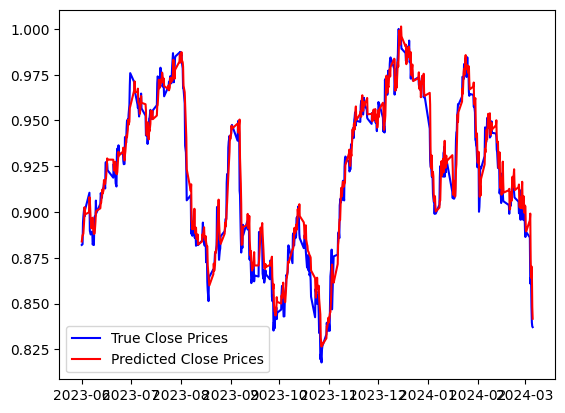

Predicted: 6556 / 6557: 170.66362518787383

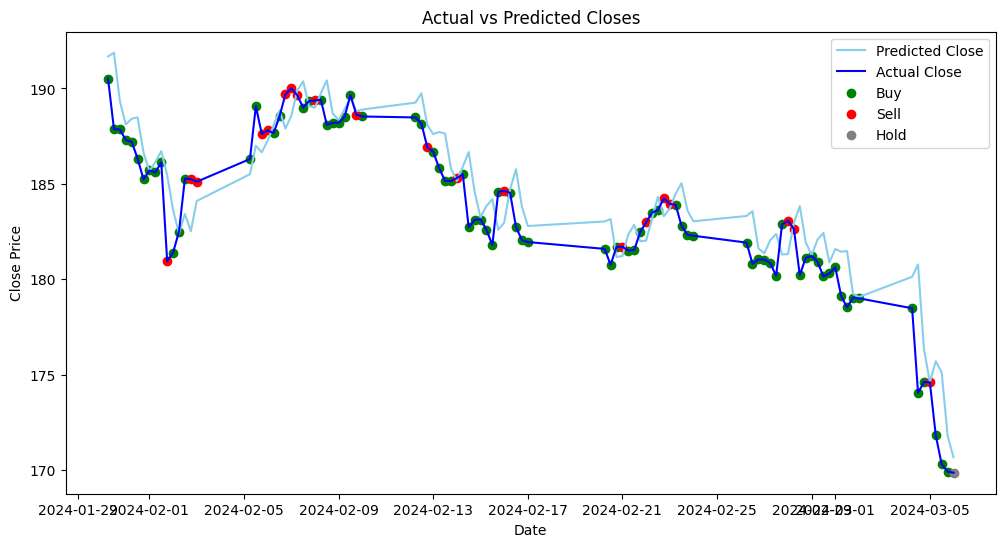

Buy     79
Sell    20
Hold     1
Name: BuySell, dtype: int64


In [7]:
should_buy, df = make_prediction(df)

In [8]:

def trade_alpaca(should_buy, df):
    # Calculate the True Range (TR)
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close-Prev'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-Close-Prev'] = abs(df['Low'] - df['Close'].shift(1))
    df['True Range'] = df[['High-Low', 'High-Close-Prev', 'Low-Close-Prev']].max(axis=1)

    # Calculate the ATR for the last day in the dataset without using a rolling average
    ATR = df['True Range'].tail(14).mean()

    # Drop intermediate columns used for calculations
    data = df.drop(['High-Low', 'High-Close-Prev', 'Low-Close-Prev', 'True Range'], axis=1)

    trading_client = TradingClient(ALPACA_API_KEY, ALPACA_SECRET_KEY, paper=True)

    account = trading_client.get_account()
    if account.trading_blocked:
        raise SystemExit("[Alpaca] Account is currently restricted from trading.")

    asset = trading_client.get_asset(SYMBOL)
    if not asset.tradable:
        raise SystemExit("[Alpaca] The requested asset is not tradable.")

    # Get current price of the stock
    all_positions = trading_client.get_all_positions()
    traded_position = None

    for position in all_positions:
        if position.symbol == SYMBOL:
            traded_position = position
            break

    last_price = df['Close'][df.index[-1]]
    current_quantity = 0
    if traded_position != None:
        last_price = float(traded_position.current_price)
        current_quantity = float(traded_position.qty)

    decision = "BUY" if should_buy else "SELL"

    # Volatility-based Position Sizing
    # Risk per Trade is the percentage of capital you are willing to risk on the trade.
    # ATR is the Average True Range, a measure of volatility.
    trade_quantity = RISK_PER_TRADE * float(account.portfolio_value) / ATR / last_price

    # Trade as much, as I can
    if decision == "SELL":
        trade_quantity = min(current_quantity, trade_quantity) 

    if SHOULD_TRADE:
        if (should_buy and float(account.buying_power) > last_price) or (not should_buy and current_quantity > 0):
            # preparing market order
            market_order_data = MarketOrderRequest(
                symbol=SYMBOL,
                qty=trade_quantity,
                side= OrderSide.BUY if should_buy else OrderSide.SELL,
                time_in_force=TimeInForce.DAY
            )

            # Market order
            market_order = trading_client.submit_order(
                order_data=market_order_data
            )
        else:
            print("Not enough buying power/quantity to trade.")
            decision = "HOLD"
    else:
        raise SystemExit("[Config] SHOULD_TRADE = False")

    return account, trade_quantity, decision, last_price


In [9]:
alpaca_account, trade_quantity, decision, last_price = trade_alpaca(should_buy, df)

SystemExit: [Config] SHOULD_TRADE = False

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:

def log_to_firestore(alpaca_account, trade_quantity, decision, last_price):
    portfolio_value = alpaca_account.portfolio_value
    date = datetime.datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%S.%fZ")

    print(f"Date: {date}")
    print(f"Budget: {portfolio_value}")
    print(f"Quantity: {trade_quantity}")
    print(f"Decision: {decision}")
    print(f"Last Price: {last_price}")

    try:
        response = requests.post(BASE_URL + "/api/firestore", headers = {
            "symbol": SYMBOL,
            "date": date,
            "portfolioValue": portfolio_value,
            "quantity": str(trade_quantity),
            "decision": decision,
            # "lastPrice": last_price,
            "admin-token": ADMIN_KEY
        })
    except requests.exceptions.RequestException as e:
        raise SystemExit(f"[/api/firestore] Request error: {e}")

    if(response.status_code != 200):
        raise SystemExit(f"[/api/firestore] Repsonse status code: {response.status_code}")


In [ ]:
log_to_firestore(alpaca_account, trade_quantity, decision, last_price)